[![Open in Colab] (https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.github.com/lucinex/VoltaML_Assignment/VIT_BERT-Flicker8K.ipynb)

In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 15.6 MB/s 
     |████████████████████████████████| 182 kB 77.5 MB/s 
     |████████████████████████████████| 7.6 MB 56.1 MB/s 


In [ ]:
!nvidia-smi

Sun Dec 18 13:07:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    28W /  70W |   1730MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
import time
import sys 
import os 

import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from PIL import Image
import PIL
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertConfig, ViTConfig, VisionEncoderDecoderConfig, ViTImageProcessor, BertTokenizer, VisionEncoderDecoderModel
# from torchtext.data.metrics import bleu_score
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(32)


def mk_dir(path):
  if not os.path.isdir(path):
    os.mkdir(path)
    print("Created new Directory {}".format(path))
  else:
    print("Directory {} already exists".format(path))

In [ ]:
print("pandas =~ "+str(pd.__version__))
print("numpy =~ "+str(np.__version__))

print("pillow =~ "+str(PIL.__version__))
print("transformers =~ "+str(transformers.__version__))
print("torch =~ "+str(torch.__version__))
print("nltk =~ "+str(nltk.__version__))
# print("torchtext =~ "+str(np.__version__))

pandas =~ 1.3.5
numpy =~ 1.21.6
pillow =~ 7.1.2
transformers =~ 4.25.1
torch =~ 1.13.0+cu116
nltk =~ 3.7


In [8]:
# run this cell to specify location and create directories 
# specify Root folder 



ROOT_PATH = "/content"  # root folder, should be same as location of this notebook 
CAPTIONS_PATH = ROOT_PATH+"/"+"FLICKER8K_CAPTIONS"
IMAGES_PATH = ROOT_PATH+"/"+"FLICKER8K_IMAGES"
mk_dir(CAPTIONS_PATH)
mk_dir(IMAGES_PATH)



Created new Directory /content/FLICKER8K_CAPTIONS
Created new Directory /content/FLICKER8K_IMAGES


Step 2: Download the datasets. They will be automatically stored in the specified directories created in step 1. 

In [9]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip /content/Flickr8k_text.zip -d $CAPTIONS_PATH


!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!unzip /content/Flickr8k_Dataset.zip -d $IMAGES_PATH

Streaming output truncated to the last 5000 lines.
  inflating: /content/FLICKER8K_IMAGES/__MACOSX/Flicker8k_Dataset/._342872408_04a2832a1b.jpg  
  inflating: /content/FLICKER8K_IMAGES/Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: /content/FLICKER8K_IMAGES/__MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: /content/FLICKER8K_IMAGES/Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: /content/FLICKER8K_IMAGES/__MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: /content/FLICKER8K_IMAGES/Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: /content/FLICKER8K_IMAGES/__MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: /content/FLICKER8K_IMAGES/Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: /content/FLICKER8K_IMAGES/__MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: /content/FLICKER8K_IMAGES/Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: /content/FLICKER8K_IMAGES/__MACO

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# And some more path variabes. 

captions_path = CAPTIONS_PATH+"/Flickr8k.token.txt"
train_labels = CAPTIONS_PATH+ "/Flickr_8k.trainImages.txt"
dev_labels = CAPTIONS_PATH+ "/Flickr_8k.devImages.txt"
test_labels = CAPTIONS_PATH+"/Flickr_8k.testImages.txt"
image_dir = IMAGES_PATH+"/Flicker8k_Dataset"


The train, dev, test split is specified in different directories. The format of the dataset is strictly followed and any other representation of the same data might not be loaded properly. 

Run this cell ! 

In [17]:
def get_filenames(path):  # generator object
  try:
    data = []
    fp = open(path,'r').readlines()
    cont = [i.split("\n")[0] for i in fp]

  except Exception as e:
    print(e)
    cont = []
    return None
  finally:
    for i in cont:
      yield i

def distribution_dataframe(train_txt,dev_txt,test_txt):
  train_files = [[i,"train"] for i in get_filenames(train_txt)]
  dev_files = [[i,"dev"] for i in get_filenames(dev_txt)]
  test_files = [[i,"test"] for i in get_filenames(test_txt)]
  all_files = train_files + dev_files + test_files
  cols = ["Filename","dist"]
  df = pd.DataFrame(all_files,columns=cols)
  return df

def get_flicker8k_dataframe(caption_path: str ):
    # get the caption
  data = []
  cols = ['Filename','Caption']

  with open(caption_path,'r') as fp:
    lines = fp.readlines()
  
    for line in lines:
      fs = line.split()
      img_file = fs[0].split("#")[0]
      caption = " ".join(fs[1:])
      data.append([img_file, caption])
  caption_df = pd.DataFrame(data,columns=cols)
  return caption_df

def get_max_sentence_length(d):
  max_len = 0
  

def preprocess_captions(field):
  stopwords = """.,?/'"]}{{+=-_)(*&#@!`~"""
  field = [ i for i in field.split(" ") if not i in stopwords]   # remove punctuations and other stopwords
  field = [i.lower() for i in field]                             # lower case

  field = " ".join(field)
  return field

class Flicker_Dataset(Dataset):
  MAX_LENGTH=40

  def __init__(self,cap_df,dist_df,image_dir,image_preprocess=None,tokenizer=None):
    self.cap_df = cap_df.groupby("Filename")
    self.dist_data = dist_df
    self.image_path = image_dir
    self.image_preprocess = image_preprocess
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.dist_data)
    
  def __getitem__(self, index):
 
    img_file = self.dist_data.iloc[index]
    
    image_path = self.get_image_path(img_file)
    image = Image.open(image_path)
    image = self.image_preprocess(image,return_tensors="pt").pixel_values
    
    cap_files = self.cap_df.get_group(img_file)
    rand_indx = random.randrange(start=0,stop=len(cap_files))
    cap = cap_files["Caption"].iloc[rand_indx]
   
    tokens = self.tokenizer(cap,add_special_tokens=True,return_tensors="pt",
                       padding="max_length",max_length=self.MAX_LENGTH).input_ids
   
    return torch.squeeze(image),torch.squeeze(tokens)
    
  def get_image_path(self,path:str):
    return self.image_path+"/"+path

class BleuEvaluator(Flicker_Dataset):
  
  def __init__(self,cap_df,dist_df,image_dir,image_preprocess=None,tokenizer=None):
    super().__init__(cap_df,dist_df,image_dir,image_preprocess,tokenizer)

  def __getitem__(self, index):
 
    img_file = self.dist_data.iloc[index]
    
    image_path = self.get_image_path(img_file)
    PILimage = Image.open(image_path)
    image = self.image_preprocess(PILimage,return_tensors="pt").pixel_values
    
    cap_files = self.cap_df.get_group(img_file)
    rand_indx = random.randrange(start=0,stop=len(cap_files))
    caps = cap_files["Caption"].values
    tokens = [ torch.squeeze(self.tokenizer(cap,add_special_tokens=True,return_tensors="pt").input_ids) for cap in caps]
   
    return dict({"PIL_Image":PILimage,"pixels":torch.squeeze(image),"captions":caps,"tokens":tokens})



class FlickerDataHandler:
  # This class handles the data according to the given structure of the directory present after cloning 

  def __init__(self,image_dir,caption_path:str, label_paths:dict(),vocab_path:str=None,
               image_processor=None, tokenizer=None):
    self.label_dist = label_paths
    self.caption_path =  caption_path
    self.image_processor = image_processor if image_processor is not None else ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
    self.tokenizer = tokenizer  if tokenizer is not None else BertTokenizer.from_pretrained("bert-base-uncased")
    self.image_dir = image_dir
    self.caption_df, self.dist_df = self.get_caption_dataframe()
    self.caption_df = self.preprocess(self.caption_df)
  

    pass
  
  def get_all_cap_data(self,dist="train"):
    if dist == "all":
      return BleuEvaluator(self.caption_df.copy(),self.dist_df["Filename"].copy(),self.image_dir,self.image_processor,self.tokenizer)
    else:
      df = self.dist_df.groupby("dist").get_group(dist)
      
      return BleuEvaluator(self.caption_df.copy(),df["Filename"].copy(),self.image_dir,self.image_processor,self.tokenizer)
  
  def get_dataset(self,dist="train"):
    
    if dist == "all":
      return Flicker_Dataset(self.caption_df.copy(),self.dist_df["Filename"].copy(),self.image_dir,self.image_processor,self.tokenizer)
    else:
      df = self.dist_df.groupby("dist").get_group(dist)
      
      return Flicker_Dataset(self.caption_df.copy(),df["Filename"].copy(),self.image_dir,self.image_processor,self.tokenizer)
      
    
  def get_dataloader(self,dist="train",batch_size=16, shuffle=False,  num_workers=2, collate_fn=None,
           pin_memory=True, prefetch_factor=2, persistent_workers=True):
     df = self.get_dataset(dist)
     dataloader = DataLoader(df , batch_size=batch_size, shuffle=shuffle,  
                             num_workers=num_workers, collate_fn=collate_fn,
                              pin_memory=pin_memory, prefetch_factor=prefetch_factor,
                              persistent_workers=persistent_workers)
     return dataloader 
  def get_caption_dataframe(self):
    caption_df = get_flicker8k_dataframe(self.caption_path)
    dist_df = distribution_dataframe(self.label_dist["train"], self.label_dist["dev"], self.label_dist["test"])

    # all_data = pd.merge(caption_df,dist_df,how="inner",on="Filename")
    
    return caption_df, dist_df
  
  def preprocess(self, dataframe):

    dataframe["Caption"] = dataframe["Caption"].apply(preprocess_captions) 
    return dataframe
  

# Data_handler = FlickerDataHandler("/content/FLICKER8K_IMAGES/Flicker8k_Dataset",
#                                   captions_path, dist_path,image_processor=image_processor,
#                                   tokenizer=tokenizer)


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


class ImgCapModel:
  MODEL_NAME = "VIT_BERT_Flicker8K"
  MAX_LENGTH=40
  # default optimizer: AdamW
  def __init__(self,  save_dir, optim ,tokenizer=None, img_processor=None,reinit=False):
    self.device = ('cuda' if torch.cuda.is_available() else 'cpu')
    
    self.tokenizer = tokenizer if tokenizer is not None else BertTokenizer.from_pretrained("bert-base-uncased")
    self.img_processor = img_processor if img_processor is not None else ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
    self.save_path = save_dir
    self.model_path = self.get_model_path()
    self.model = self.init_model(self.model_path,reinit).to(self.device)
    self.optim = optim
    self.early_stopper = EarlyStopper(patience=2,min_delta=0.1)
    self.smoothing_fn = SmoothingFunction().method1



  
  def init_model(self,path,reinit=False):
    if os.path.isdir(path) and (not reinit):
      print("Found previous weights, Loading with pre_trained weights")
      encoder_decoder_config = VisionEncoderDecoderConfig.from_pretrained(path)
      model = VisionEncoderDecoderModel.from_pretrained(path, config=encoder_decoder_config)
    else:
      print("Path to model does not exist. Loading base-pretrained weights, Need to be trained.")
      model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
            "google/vit-base-patch16-224-in21k", "bert-base-uncased")
      model.config.decoder_start_token_id = 101
      model.config.pad_token_id = 0
      model.config.decoder.is_decoder=True
      model.config.decoder.add_cross_attention=True
      model.save_pretrained(path)
    # model.config.decoder.is_decoder=True
    # model.config.decoder.add_cross_attention=True
    return model
  
  def evaluate_blue_score(self,pred_tokens, target_tokens):
    assert pred_tokens.shape == target_tokens.shape, "Invalid input"
    

   
    preds = self.tokenizer.batch_decode(pred_tokens) 
    targets = self.tokenizer.batch_decode(target_tokens)
    preds = [[i for i in pred.split(" ") if i not in [self.tokenizer.convert_ids_to_tokens(0)]] for pred in preds]
    targets = [[i for i in target.split(" ")  if i not in [self.tokenizer.convert_ids_to_tokens(0)]] for target in targets]
    bleu = []

    for i in range(len(preds)):
      bleu.append(sentence_bleu([targets[i]],preds[i],
                           weights=(0.25, 0.25, 0.25, 0.25),
                           smoothing_function=None ,smoothing_fn=self.smoothing_fn))
    return np.mean(bleu)
  
  def generate(self,image):
    # greedy decoing
    self.model.eval()
    image = image.to(self.device)
    # pad_tokens = torch.zeros([image.shape[0],self.MAX_LENGTH],dtype=torch.int32).to(self.device)
    # output = self.model(image,pad_tokens).logits
    # _,output = torch.max(output,axis=-1)
    # # output = output
    # print(output)

    num_beams= 4
    
    gen_kwargs = {"max_length":self.MAX_LENGTH, "num_beams": num_beams}
    # # image = self.img_processor(image,return_tensors="pt").pixel_values
    image = image.to(self.device)
    output = self.model.generate(image,**gen_kwargs)[0]   
    output = self.tokenizer.batch_decode(output, skip_special_tokens=True)
    return output

  def get_model_path(self):
    return self.save_path + "/" + self.MODEL_NAME 

  def train(self, tr_dataloader, val_dataloader, epochs,warmup = 1,learning_rt=1e-3, loss_fn=None ):
    # train
    
    optim = self.optim(self.model.parameters(),lr=learning_rt)
    schedular = get_linear_schedule_with_warmup(
                      optim, num_warmup_steps=warmup, 
                      num_training_steps=epochs+1)
    history = {}
    history['loss'] = []
    history['val_loss'] = []
    history['accuracy'] = []
    history['val_accuracy'] = []
    start_time_sec = time.time()
    for epoch in range(1, epochs+1):
      print(" Epoch {}: \n".format(epoch))
      print(" Training \n")
      accuracy, loss = self.train_one_epoch(tr_dataloader,optim,schedular,loss_fn)
      print("Going For Validation!\n")
      val_loss, val_accuracy  = self.evaluate(val_dataloader,loss_fn)
      print("Validation Loss : {0:.3f}   Validation Accuracy: {0:.3f}".format(val_loss, val_accuracy ))
      history['loss'].append(loss)
      history['val_loss'].append(val_loss)
      history['accuracy'].append(accuracy)
      history['val_accuracy'].append(val_accuracy)
      #history['val_bleu_score'].append(val_bleu_score)

      if self.early_stopper.early_stop(val_loss):
        print("Early stoping at epoch ->", epoch)
        break
    self.save()
    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print("Total Time Taken {0:.3f}".format(total_time_sec))
    return history 
    
  def train_one_epoch(self,dataloader,optim,scheduler,loss_fn):
    start_time_sec = time.time()
    self.model.train()

    losses = []
    accuracy = []
    batches = len(dataloader)
    step = 0
    for image,input_ids in dataloader:
      step+=1
      input_ids = input_ids.to(self.device)
      targets = image.to(self.device)

      outputs = self.model(
          pixel_values=targets,
          labels=input_ids)
      # print(torch.permute(outputs.logits,dims=[0,2,1]).shape)
      if loss_fn is not None:
        loss = loss_fn(torch.permute(outputs.logits,dims=[0,2,1]),input_ids)
      else:
        loss = outputs.loss
      
      _, preds = torch.max(outputs.logits, dim=-1)
      accuracy.append((torch.sum(preds == input_ids)/(preds.shape[0]*preds.shape[1])).cpu())
      losses.append(loss.item())
      print("\r Step: {} / {} \t".format(step, batches), end=" ",flush=True)
      print(" Loss: {0:.6f} \t".format(np.mean(losses)), end="",flush=True)
      #sys.stdout.write("\033[F")
      loss.backward()
      # torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
      optim.step()
      scheduler.step()
      optim.zero_grad()
     

    acc,losses =  np.mean(accuracy), np.mean(losses)
    print("Training Accuracy: {0:.6f}".format(acc))
    
    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print("Train Time {0:.3f}".format(total_time_sec))
    return acc, losses

  def evaluate(self,dataloader,loss_fn=None):
    self.model.eval()
    val_loss = []
    val_bleu_score = []
    accuracy = []
    counter = 0
    batches = len(dataloader)
    for image,input_ids in dataloader:
      counter +=1
      input_ids = input_ids.to(self.device)
      pixels = image.to(self.device)

      outputs = self.model(
          pixel_values=pixels,
          labels=input_ids)
      if loss_fn is not None:
        loss = loss_fn(torch.permute(outputs.logits,dims=[0,2,1]),input_ids)
      else:
        loss = outputs.loss
      val_loss.append(loss.item())
      print("\r Step: {} / {} \t".format(counter, batches), end=" ",flush=True)
      print("Val Loss: {0:.6f} \t".format(np.mean(val_loss)), end=" ",flush=True)
      _, preds = torch.max(outputs.logits, dim=-1)
      accuracy.append((torch.sum(preds == input_ids)/(preds.shape[0]*preds.shape[1])).cpu())
      # val_bleu_score.append(self.evaluate_blue_score(preds,input_ids))
    return np.mean(val_loss), np.mean(accuracy)
  
  def save(self):
    self.model.save_pretrained(self.model_path)
    print(f"model saved to path {self.model_path}  ")
    return




def generate_examples(DataHandlerObj: FlickerDataHandler, model: ImgCapModel=None, n_examples= 10, dist="train"):
  df = DataHandlerObj.get_all_cap_data(dist)
  length = len(df)
  rand_indx = random.choices([i for i in range(length)],k=n_examples)
  cout = 1
  for i in rand_indx:
    plt.figure()
    
    data = df[i]
    
    print(f"Sample {cout}")
    print("\t Captions ")
    
    for i in data["captions"]:
        print(i)
    print("\n")
    img = data["PIL_Image"]
    plt.imshow(img)
    pixels = data["pixels"]
    if model is not None:
  
      predictions = model.generate(torch.unsqueeze(pixels,axis=0))
      print("Predictions: {}".format(predictions))
    print("\n")
    plt.show()
    cout+=1
  return

Load 

In [11]:
# transformer input processors 
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
# load Dataset Handler obj. 
dist_path = {"train":train_labels,"dev":dev_labels,"test":test_labels}
Data_handler = FlickerDataHandler(image_dir,
                                  captions_path, dist_path,image_processor=image_processor,
                                  tokenizer=tokenizer)
# get pytorch dataloaders
train_df = Data_handler.get_dataloader("train",batch_size=32, shuffle=True)
val_df = Data_handler.get_dataloader("dev",batch_size=4)
test_df = Data_handler.get_dataloader("test",batch_size=4)

#


Look at Train size and Dev size

In [ ]:
len(val_df)

30000

In [ ]:
len(train_df)

1875

Looking at some of the captions, after exploring other repositories about works done on Flicker8K, we get a MAX_LENGTH of sentences to be 40. Further, we do not preprocess for stopwords, as the hugging face tokenizer contains special character tokens, and want the transformer to learn the indepth relation among them. 

In [24]:
Data_handler.caption_df

,Filename,Caption
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
...,...,...
40455,997722733_0cb5439472.jpg,a man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg,a man is rock climbing high in the air
40457,997722733_0cb5439472.jpg,a person in a red shirt climbing up a rock fac...
40458,997722733_0cb5439472.jpg,a rock climber in a red shirt


In [18]:
model = ImgCapModel(ROOT_PATH ,optim = AdamW , img_processor=image_processor,
                                  tokenizer=tokenizer,reinit=False)

Found previous weights, Loading with pre_trained weights


In [ ]:
CE_loss = torch.nn.CrossEntropyLoss()

In [ ]:
history = model.train(train_df,val_df,epochs=5,learning_rt=1e-3,loss_fn =CE_loss )

 Epoch 1: 

 Training 



/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Step: 188 / 188 	  Loss: 4.934182 	Training Accuracy: 0.646775
Train Time 305.440
Going For Validation!

 Step: 250 / 250 	 Val Loss: 4.733893 	 Validation Loss : 4.734   Validation Accuracy: 4.734
 Epoch 2: 

 Training 

 Step: 188 / 188 	  Loss: 4.785321 	Training Accuracy: 0.657389
Train Time 313.609
Going For Validation!

 Step: 250 / 250 	 Val Loss: 4.710696 	 Validation Loss : 4.711   Validation Accuracy: 4.711
 Epoch 3: 

 Training 

 Step: 188 / 188 	  Loss: 4.787326 	Training Accuracy: 0.657260
Train Time 313.367
Going For Validation!

 Step: 250 / 250 	 Val Loss: 4.730833 	 Validation Loss : 4.731   Validation Accuracy: 4.731
 Epoch 4: 

 Training 

 Step: 188 / 188 	  Loss: 4.788765 	Training Accuracy: 0.657044
Train Time 314.232
Going For Validation!

 Step: 250 / 250 	 Val Loss: 4.722655 	 Validation Loss : 4.723   Validation Accuracy: 4.723
 Epoch 5: 

 Training 

 Step: 188 / 188 	  Loss: 4.776140 	Training Accuracy: 0.658428
Train Time 313.693
Going For Validation!

 S

In [ ]:
# print history
for item in history.items():
  print(item)

('loss', [4.9341816242705, 4.785321009919999, 4.787325843851617, 4.788765496396004, 4.776140344903824])
('val_loss', [4.7338933219909665, 4.710695901870728, 4.730832789421082, 4.7226545543670655, 4.7101865482330325])
('accuracy', [0.64677525, 0.6573887, 0.6572598, 0.65704376, 0.65842754])
('val_accuracy', [0.66382504, 0.6661, 0.66347504, 0.66507494, 0.6661])


In [ ]:
# test data score
test_loss, test_acc = model.evaluate(test_df,CE_loss)
print("Test Accuracy: {}".format(test_acc))

 Step: 250 / 250 	 Val Loss: 4.699850 	 Test Accuracy: 0.6665749549865723


Looking at some predictions 

Sample 1
	 Captions 
a bird is flying through the air
a blue heron flying
a gray egret takes flight
a large bird is in mid flight
a pelican flies through the air in front of trees


Predictions: ['[ C L S ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]']




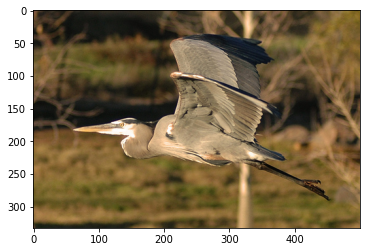

Sample 2
	 Captions 
the boy laying face down on a skateboard is being pushed along the ground by another boy
two girls play on a skateboard in a courtyard
two people play on a long skateboard
two small children in red shirts playing on a skateboard
two young children on a skateboard going across a sidewalk


Predictions: ['[ C L S ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]']




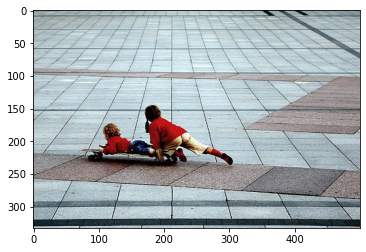

Sample 3
	 Captions 
a group of men stands near a tree as a racing car stirs up a cloud of dust on the gravel road beside them
a race car kicks up dirt and dust on a gravel track
many people stand by watching a car smoke heavily
people are watching a race car speed thorugh the dirt
six spectators watching a dirt racing car pass by in a cloud of dust


Predictions: ['[ C L S ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]']




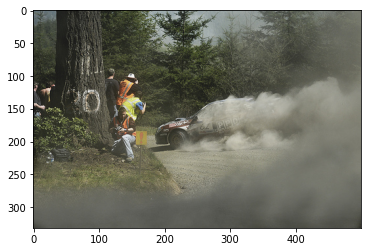

Sample 4
	 Captions 
a big brown dog running
a brindle do runs through a grassy yard
a brown dog runs outdoors
a grayhound dog is sprinting
dog running in yard


Predictions: ['[ C L S ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]']




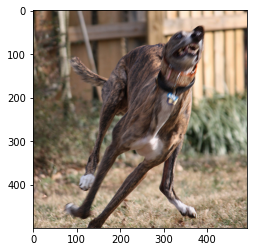

Sample 5
	 Captions 
an elderly middle-eastern woman is about to smoke a pack of cigarettes
a middle eastern woman wearing green is sitting on a stone step holding a box of cigarettes
a woman in an orange scarf pulls a pack of cigarettes from a carton
a woman wearing a long green dress and scarves on her head holding a pack of cigarettes and a carton of winston cigarettes by a stone structure
woman with red headscarf and green dress holding cigarette carton and sitting on concrete steps


Predictions: ['[ C L S ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]'

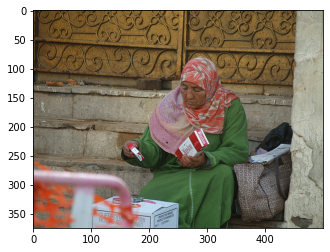

Sample 6
	 Captions 
a boy is jumping forwards down a water slide
a boy jumps onto a inflatable water slide
a boy on a water slide
a boy wearing a blue swimsuit begins to slide down a water slide
a person in swim trunks jumping down an inflatable slide


Predictions: ['[ C L S ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]']




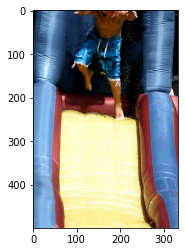

Sample 7
	 Captions 
a hockey player in red untangles from a player in white as he goes for the puck
two hockey players almost fall on the ice during a scuffle
two hockey players compete on the ice
two hockey players fighting on the ice
two hockey players in a struggle on the ice


Predictions: ['[ C L S ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]']




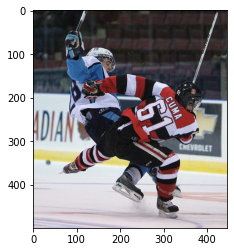

Sample 8
	 Captions 
a little girl in a pink hat sniffing a white flower
a little girl smelling a flower
a young girl is smelling the flowers
little girl with knit cap smelling flowers
the young child looked up toward the white flowers


Predictions: ['[ C L S ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]']




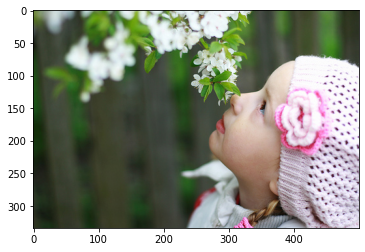

Sample 9
	 Captions 
a football player folding a football during a game in the mud
american footballers in yellow outfits are playing in a very muddy field
a young football player in a muddy yellow and blue uniform carrying a football with other muddy players run behind him
football players playing in mud
football players playing in the mud


Predictions: ['[ C L S ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]']




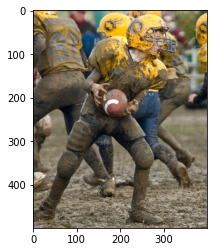

Sample 10
	 Captions 
a man jumps off a ramp on a snowboard
a snowboarder high in the air
a snowboarder jumps through the air on their snowboard
snowboarder flies off of snowy jump mountains in background
the snowboarder is in the middle of a very tall jump


Predictions: ['[ C L S ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]']




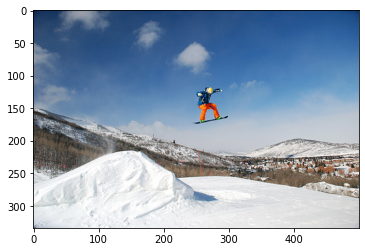

In [22]:
generate_examples(Data_handler,model,dist="dev")

Remarks: We See that the transformer was not properly trained. The captions generated are gibberish and may require more data than 30k text examples.

Further, I have not looked into the soure code of EncoderDecoderVisionModel from the transformer library and would be looking into coding the encoder decoder model. 